Generates data using factor models with 2 factors and a smooth time-varying factor loading and residuals from i.i.d multivariate normal distribution with an identity matrix as its covariance matrix.


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

def data_generate_setting2(p, T, rho, seed=1234):
    """Generate data for a factor model with smooth time-varying factor loadings.

    Args:
        p: Dimension of the portfolio.
        T: Sample size.
        rho: Autoregressive coefficient in the factor loadings that controls the
             departure from constant factor loading.

    Returns:
        Y: A (p, T) matrix of asset returns.
        r_cov: The covariance matrix of Y.
        s_cov: The cross-sectional covariance matrix of the residuals.
    """
    np.random.seed(seed)
    subt = np.arange(1, T+1) / T  # generate scaled time

    loading1 = np.zeros((p, T))
    loading2 = np.zeros((p, T))
    for subi in range(p):
        z = rho * ((3 + np.random.randn()) * subt + np.random.randn() * np.sin(4 * np.pi * subt)) + np.random.randn()
        z2 = rho * ((3 + np.random.randn()) * subt + np.random.randn() * np.sin(4 * np.pi * subt) + (np.random.randn() * subt) ** 2) + np.random.randn()
        loading1[subi, :] = z
        loading2[subi, :] = z2

    s_cov = np.zeros((p, p))
    for i in range(p):
        for j in range(i + 1, p):
            s_cov[i, j] = ((0.5) ** abs(j - i))
            s_cov[j, i] = s_cov[i, j]
    s_cov = s_cov + np.eye(p)
    r_cov = np.matmul(np.column_stack((loading1[:, T-1], loading2[:, T-1])), np.column_stack((loading1[:, T-1], loading2[:, T-1])).T) + s_cov

    F1_set = np.zeros(T + 200)
    """
    The value 200 is a predefined constant used in the calculation of the factors
    F1 and F2. Specifically, this value determines the "burn-in" period, or the number of initial time steps that are
    calculated but then discarded when constructing the final time series!
    """

    F2_set = np.zeros(T + 200)
    F1_t0 = np.random.randn()
    F2_t0 = np.random.randn()
    for j in range(T + 200):
        F1_t = 0.6 * F1_t0 + multivariate_normal.rvs(mean=0, cov=0.64, size=1)
        F1_set[j] = F1_t
        F1_t0 = F1_t
        F2_t = 0.3 * F2_t0 + multivariate_normal.rvs(mean=0, cov=0.91, size=1)
        F2_set[j] = F2_t
        F2_t0 = F2_t

    F = np.vstack((F1_set[200:200 + T], F2_set[200:200 + T])) # Transpose F

    x_k = multivariate_normal.rvs(mean=np.zeros(p), cov=s_cov, size=T).T
    fa_part = np.zeros((p, T))
    for qq in range(T):
        B1_temp = np.column_stack((loading1[:, qq], loading2[:, qq]))
        fa_part[:, qq] = B1_temp.dot(F[:, qq]) # Multiply by the qq-th column of F

    Y = fa_part + x_k
    Y_df = pd.DataFrame(Y.T)

    return Y_df, r_cov, s_cov

In [ ]:
# Example usage with specific values for p, T, and rho
p = 50
T = 250
rho = 1
returns = data_generate_setting2(p, T, rho)
returns[0].head(3)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-1.375803,2.328461,-0.044009,1.789765,-0.870633,0.816486,-1.384257,-0.711093,-1.547154,-1.376662,...,2.397960,-1.759085,-0.569317,-0.899740,-0.687166,-0.801776,-1.582356,-0.873801,-1.311927,1.343921
1,-0.613344,-1.626443,-0.755399,-0.299498,1.204670,1.959998,0.430078,0.709686,2.179894,0.200363,...,-2.622753,-1.781713,-0.572837,2.882800,-0.122843,1.421630,1.120925,1.762025,1.320782,1.850252
2,-0.278693,-3.077959,-0.246658,0.212810,-2.214439,-2.829347,-1.172359,-1.137017,1.254358,-3.531449,...,-2.832065,0.055384,0.539616,2.738915,0.642317,0.487009,-0.325525,1.340461,1.161383,-0.706894


<Axes: >

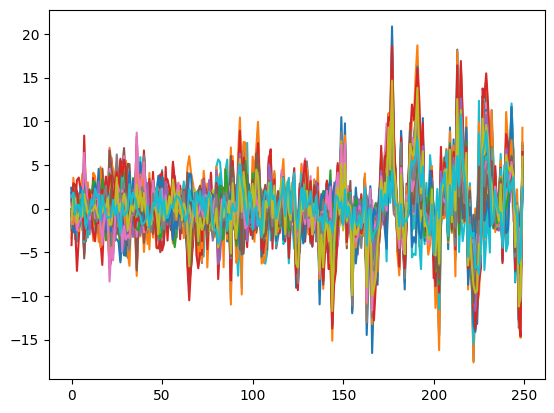

In [ ]:
returns[0].plot(legend = False)